# **Necessary Imports**

In [101]:
!pip install keras-tuner --quiet
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, mixed_precision
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_score, recall_score, log_loss, roc_curve, roc_auc_score, brier_score_loss, precision_recall_curve, confusion_matrix,)
import plotly.express as px
from sklearn.linear_model import LogisticRegression
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import AUC
mixed_precision.set_global_policy("mixed_float16")

# **Loading the data**

In [36]:
df = pd.read_csv("/content/drive/MyDrive/final_dataset.csv")
df = df.sort_values(["match_id", "t"])
df = df.fillna(0)
df.sample(5)

,match_id,t,gold_blue,gold_red,xp_blue,xp_red,gold_diff,xp_diff,cs_lane_t1,cs_lane_t2,...,totdmgdealt_blue,totdmgdealt_red,totdmgtochamp_blue,totdmgtochamp_red,totheal_blue,totheal_red,wardsplaced_blue,wardsplaced_red,wardskilled_blue,wardskilled_red
61519,EUW1_7489359447,1220,43919.0,37254.0,47659.0,43513.0,6665.0,4146.0,543.0,554.0,...,160220.2,113999.0,20490.8,15883.4,6499.4,7001.6,13.4,13.2,4.6,5.8
366904,EUW1_7597152512,610,16583.0,16354.0,18771.0,19811.0,229.0,-1040.0,242.0,243.0,...,253417.0,195240.8,35600.6,33755.6,11705.8,11338.6,17.0,20.0,9.2,7.2
20077,EUW1_7459473989,270,6251.0,6487.0,5861.0,6302.0,-236.0,-441.0,83.0,81.0,...,154496.2,166559.6,21193.6,25473.4,8039.2,14466.0,18.2,18.2,1.4,6.4
293644,EUW1_7584746392,1380,41515.0,45327.0,49572.0,61071.0,-3812.0,-11499.0,578.0,621.0,...,124652.8,171867.6,16773.0,25469.4,17662.8,9348.8,12.2,16.2,6.6,3.4
406672,EUW1_7605119491,880,26384.0,23207.0,29138.0,26493.0,3177.0,2645.0,375.0,326.0,...,147878.8,98462.2,18079.2,11791.6,6153.6,7738.6,14.0,14.2,3.2,3.6


# **Feature Engineering**

In [37]:
target_columns = ["y_baron_10", "y_baron_20", "y_baron_30", "y_dragon_10", "y_dragon_20", "y_dragon_30", "y_teamfight_10", "y_teamfight_20", "y_teamfight_30"]

exclude_columns = ["match_id", "t"]
for col in target_columns:
    exclude_columns.append(col)

feature_columns = []
for col in df.columns:
    if col not in exclude_columns:
        feature_columns.append(col)

for col in feature_columns:
    new_col_name = col + "_diff"
    tmp = df.groupby("match_id")[col].diff()
    tmp = tmp.fillna(0)
    df[new_col_name] = tmp

feature_columns = []
for col in df.columns:
    if col not in exclude_columns:
        feature_columns.append(col)

print("Num features:", len(feature_columns))
print("Num targets:", len(target_columns))
scaler = StandardScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

Num features: 150
Num targets: 9


# **Buidling sequences and augmenting data**

In [38]:
SEQ_LEN = 40
STEP = 5

def make_seq(df, feature_columns, target_columns, seq_len=40, step=5):
    xs = []  # all sequences from all matches
    ys = []  # all targets from all matches

    for match_id, g in df.groupby("match_id"):
        g = g.sort_values("t")
        xf = g[feature_columns].values.astype(np.float32)
        yt = g[target_columns].values.astype(np.float32)

        if len(xf) < seq_len:
            continue

        seq_list = []   # sequences just for this match
        targ_list = []  # targets just for this match

        for start_idx in range(0, len(xf) - seq_len + 1, step):
            end_idx = start_idx + seq_len

            x_window = xf[start_idx:end_idx]
            y_window = yt[end_idx - 1]

            seq_list.append(x_window)
            targ_list.append(y_window)

        seq_arr = np.array(seq_list, dtype=np.float32)
        targ_arr = np.array(targ_list, dtype=np.float32)

        xs.append(seq_arr)
        ys.append(targ_arr)

    X_all = np.concatenate(xs, axis=0)
    Y_all = np.concatenate(ys, axis=0)

    return X_all, Y_all


def jitter_seq(x, y, shift=2, repeat=2):
    n, t, f = x.shape

    xs = [x]
    ys = [y]

    for _ in range(repeat):
        shifts = np.random.randint(-shift, shift + 1, size=n)
        pad_x = np.pad(x, pad_width=((0, 0), (shift, shift), (0, 0)), mode="reflect")
        new_x = np.zeros_like(x)

        for i in range(n):
            s = shifts[i]
            start_idx = s + shift
            end_idx = start_idx + t
            new_x[i] = pad_x[i, start_idx:end_idx, :]

        xs.append(new_x)
        ys.append(y)

    X_out = np.concatenate(xs, axis=0)
    Y_out = np.concatenate(ys, axis=0)

    return X_out, Y_out


X_seq, y_seq = make_seq(df, feature_columns, target_columns, seq_len=SEQ_LEN, step=STEP)
print("Raw sequences:", X_seq.shape, y_seq.shape)

X_aug, y_aug = jitter_seq(X_seq, y_seq, shift=2, repeat=2)
print("Augmented sequences:", X_aug.shape, y_aug.shape)

Raw sequences: (74728, 40, 150) (74728, 9)
Augmented sequences: (224184, 40, 150) (224184, 9)


# **Train/Val/Test Split**

In [39]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X_aug, y_aug, test_size=0.10, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.20, random_state=42)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape,   y_val.shape)
print("Test: ", X_test.shape,  y_test.shape)

np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("X_val.npy",   X_val)
np.save("y_val.npy",   y_val)
np.save("X_test.npy",  X_test)
np.save("y_test.npy",  y_test)

BATCH_SIZE = 256

def make_ds(x, y, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((x, y))

    if shuffle:
        ds = ds.shuffle(8910, reshuffle_each_iteration=True)

    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    # manually slicing targets into dict
    def split_targets(a, b):
        # since we have 9 targets
        baron_targets = b[:, 0:3]      # y_baron_10,20,30
        dragon_targets = b[:, 3:6]     # y_dragon_10,20,30
        teamfight_targets = b[:, 6:9]  # y_teamfight_10,20,30

        return a, {
            "baron": baron_targets,
            "dragon": dragon_targets,
            "teamfight": teamfight_targets
        }

    ds = ds.map(split_targets)
    return ds

train_ds = make_ds(X_train, y_train, shuffle=True)
val_ds   = make_ds(X_val,   y_val,   shuffle=False)

Train: (161412, 40, 150) (161412, 9)
Val:   (40353, 40, 150) (40353, 9)
Test:  (22419, 40, 150) (22419, 9)


# **Logistic Regression - model**

In [40]:
# flattening the time dimension
Xtr_last = X_train[:, -1, :].astype(np.float32)
Xva_last = X_val[:,   -1, :].astype(np.float32)
Xte_last = X_test[:,  -1, :].astype(np.float32)

# shove train + val together
X_base = np.concatenate([Xtr_last, Xva_last], axis=0)
y_base = np.concatenate([y_train,  y_val],   axis=0)

def train_logistic_per_label(X, y):
    model_list = []
    for col in range(y.shape[1]):
        lr = LogisticRegression(max_iter=300, solver="liblinear", class_weight="balanced")
        lr.fit(X, y[:, col])
        model_list.append(lr)

    return model_list

logit_models = train_logistic_per_label(X_base, y_base)

def predict_logit(model_list, X):
    out_probs = []
    for m in model_list:
        p = m.predict_proba(X)[:, 1]
        out_probs.append(p)
    return np.stack(out_probs, axis=1)

y_test_pred = predict_logit(logit_models, Xte_last)

# **Logistic Regression - metrics**

In [41]:
event_horizons = [
    ("Baron", 10), ("Baron", 20), ("Baron", 30),
     ("Dragon", 10), ("Dragon", 20), ("Dragon", 30),
      ("Teamfight", 10), ("Teamfight", 20), ("Teamfight", 30)
]

# turning them into names like "Baron_10"
event_names = []
for e, h in event_horizons:
    event_names.append(e + "_" + str(h))

# mapping the event name to its index in the label matrix
event_to_idx = {}
for i, name in enumerate(event_names):
    event_to_idx[name] = i
rows = []

for name, idx in event_to_idx.items():
    yt = y_test[:, idx].astype(int)
    yp = y_test_pred[:, idx]

    # check if all labels are the same
    if yt.min() == yt.max():
        auc_val = np.nan
        brier_val = np.nan
    else:
        auc_val = roc_auc_score(yt, yp)
        brier_val = brier_score_loss(yt, yp)

    y_bin = (yp >= 0.5).astype(int)
    prec_val = precision_score(yt, y_bin, zero_division=0)

    # break name back into event and horizon
    tmp = name.split("_")
    base_name = tmp[0]
    the_horizon = int(tmp[1])

    row = {
        "event": base_name,
        "horizon": the_horizon,
        "auc": auc_val,
        "precision": prec_val,
        "brier": brier_val
    }
    rows.append(row)

df_metrics = pd.DataFrame(rows)
df_metrics = df_metrics.sort_values(["event", "horizon"])

event_avg = (df_metrics.groupby("event")[["auc", "precision", "brier"]].mean().reset_index())
display(event_avg)

,event,auc,precision,brier
0,Baron,0.965520,0.079331,0.074304
1,Dragon,0.693522,0.087861,0.223109
2,Teamfight,0.727050,0.150254,0.212319


# **Logistic Regression - Confusion matrix**

In [49]:
def plot_main_conf_mats_baseline():
    main_events = ["Baron_30", "Dragon_30", "Teamfight_30"]

    map_labels = {
        "Baron":      ("No Baron",      "Baron"),
        "Dragon":     ("No Dragon",     "Dragon"),
        "Teamfight":  ("No Teamfight",  "Teamfight")
    }

    for ev_name in main_events:
        idx = event_to_idx[ev_name]
        yt = y_test[:, idx].astype(int)
        yp = y_test_pred[:, idx]
        yb = (yp >= 0.5).astype(int)
        cm = confusion_matrix(yt, yb, labels=[0, 1])
        base = ev_name.split("_")[0]
        true0, true1 = map_labels[base]
        fig = px.imshow(
            cm,
            text_auto=True,
            x=[f"{true0}", f"{true1}"],
            y=[f"{true0}", f"{true1}"],
            labels=dict(x="Predicted", y="Actual", color="Count"),
            title=base,
            color_continuous_scale="Blues"
        )

        fig.update_layout(width=350, height=350)
        fig.show()

plot_main_conf_mats_baseline()

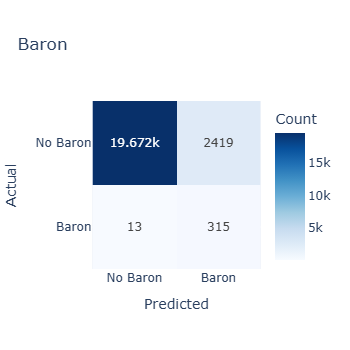

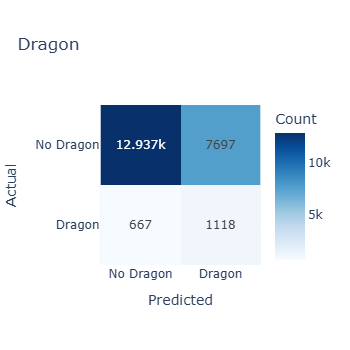

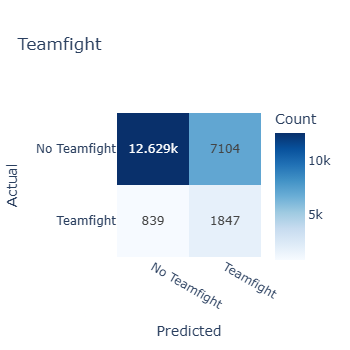

# **Logistic Regression - ROC curve**

In [43]:
def plot_roc_30_baseline():
    fig = go.Figure()
    the_events = ["Baron_30", "Dragon_30", "Teamfight_30"]

    for ev in the_events:
        idx = event_to_idx[ev]
        y_true = y_test[:, idx].astype(int)
        y_prob = y_test_pred[:, idx]
        if y_true.min() == y_true.max():
            continue

        fpr, tpr, thr = roc_curve(y_true, y_prob)
        auc_val = roc_auc_score(y_true, y_prob)

        label_name = ev.split("_")[0]
        leg_text = label_name + " (AUC = " + format(auc_val, ".3f") + ")"

        fig.add_trace(
            go.Scatter(
                x=fpr,
                y=tpr,
                mode="lines",
                name=leg_text
            )
        )

    fig.add_trace(
        go.Scatter(
            x=[0, 1],
            y=[0, 1],
            mode="lines",
            line=dict(dash="dash"),
            name="Random"
        )
    )

    fig.update_layout(
        title="ROC curve - Logistic Regression",
        xaxis_title="False Positive Rate",
        yaxis_title="True Positive Rate",
        xaxis=dict(range=[0, 1]),
        yaxis=dict(range=[0, 1]),
        width=750,
        height=550
    )

    fig.show()

plot_roc_30_baseline()


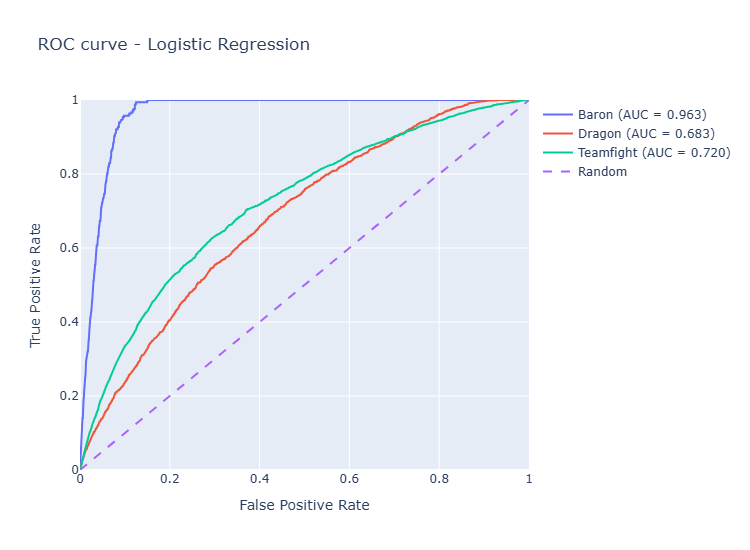

# **Logistic Regression - risk plot**

In [98]:
def build_match_sequences(df, match_id, seq_len, step):
    g = df[df["match_id"] == match_id].sort_values("t").reset_index(drop=True)
    feats = g[feature_columns].values.astype(np.float32)
    targs = g[target_columns].values.astype(np.float32)

    xs, ys, ts = [], [], []

    for start_idx in range(0, len(g) - seq_len + 1, step):
        end_idx = start_idx + seq_len - 1
        xs.append(feats[start_idx:end_idx+1])
        ys.append(targs[end_idx])
        ts.append(g.loc[end_idx, "t"])

    if len(xs) == 0:
        return (
            np.empty((0, seq_len, len(feature_columns)), np.float32),
            np.empty((0, len(target_columns)), np.float32),
            np.empty((0,), np.float32)
        )

    return np.array(xs), np.array(ys), np.array(ts, dtype=np.float32)


def baseline_seq_predict(X_seq):
    X_last = X_seq[:, -1, :].reshape(-1, X_seq.shape[-1])
    probs_all = predict_logit(logit_models, X_last)
    baron_p     = probs_all[:, 0:3]
    dragon_p    = probs_all[:, 3:6]
    teamfight_p = probs_all[:, 6:9]
    return baron_p, dragon_p, teamfight_p


def pick_warnings(probabilities, t_sec, prob_floor, min_gap_s=45, max_warn=3):
    cand = np.where(probabilities >= prob_floor)[0]
    if len(cand) == 0:
        return np.array([], dtype=int)

    clusters = []
    cur = [cand[0]]

    for idx in cand[1:]:
        if t_sec[idx] - t_sec[cur[-1]] <= min_gap_s:
            cur.append(idx)
        else:
            clusters.append(cur)
            cur = [idx]

    clusters.append(cur)

    picks = []
    for c in clusters:
        c_arr = np.array(c)
        best = c_arr[np.argmax(probabilities[c_arr])]
        picks.append(best)

    picks = np.array(picks)

    if len(picks) > max_warn:
        order = np.argsort(probabilities[picks])[::-1][:max_warn]
        picks = picks[order]

    return picks


def plot_ews_dashboard_baseline(match_id):
    X_seq, Y_seq, T_seconds = build_match_sequences(df, match_id, SEQ_LEN, STEP)
    if X_seq.shape[0] == 0:
        print("No sequences for match", match_id)
        return

    T_minutes = T_seconds / 60.0
    baron_p, dragon_p, teamfight_p = baseline_seq_predict(X_seq)

    cfg = {
        "Teamfight": {"probs": teamfight_p[:, 2], "y_col": "y_teamfight_30", "color": "red",  "prob_floor": 0.25, "max_warn": 3},
        "Dragon":    {"probs": dragon_p[:, 2],    "y_col": "y_dragon_30",    "color": "green","prob_floor": 0.20, "max_warn": 2},
        "Baron":     {"probs": baron_p[:, 2],     "y_col": "y_baron_30",     "color": "blue", "prob_floor": 0.12, "max_warn": 2},
    }

    fig = make_subplots(
        rows=3, cols=1, shared_xaxes=True,
        vertical_spacing=0.05,
        subplot_titles=[
            "Teamfight 30s risk (logistic)",
            "Dragon 30s risk (logistic)",
            "Baron 30s risk (logistic)"
        ]
    )

    fig.add_trace(go.Scatter(x=[None], y=[None], mode="lines",
                             line=dict(color="red"),
                             name="Teamfight risk"), row=1, col=1)
    fig.add_trace(go.Scatter(x=[None], y=[None], mode="lines",
                             line=dict(color="green"),
                             name="Dragon risk"), row=1, col=1)
    fig.add_trace(go.Scatter(x=[None], y=[None], mode="lines",
                             line=dict(color="blue"),
                             name="Baron risk"), row=1, col=1)

    fig.add_trace(go.Scatter(x=[None], y=[None], mode="markers",
                             marker=dict(symbol="triangle-up", color="red"),
                             name="Red caution (event coming)"), row=1, col=1)

    fig.add_trace(go.Scatter(x=[None], y=[None], mode="markers",
                             marker=dict(symbol="triangle-up", color="gold"),
                             name="Yellow caution (no event)"), row=1, col=1)

    event_order = ["Teamfight", "Dragon", "Baron"]

    for row_num, ev_name in enumerate(event_order, start=1):

        stuff = cfg[ev_name]
        probs = stuff["probs"]

        target_idx = target_columns.index(stuff["y_col"])
        y_true = Y_seq[:, target_idx].astype(int)

        warnings = pick_warnings(
            probs, T_seconds,
            prob_floor=stuff["prob_floor"],
            min_gap_s=45,
            max_warn=stuff["max_warn"]
        )

        hit_idx  = warnings[y_true[warnings] == 1]
        miss_idx = warnings[y_true[warnings] == 0]

        fig.add_trace(
            go.Scatter(
                x=T_minutes, y=probs,
                mode="lines+markers",
                line=dict(color=stuff["color"]),
                name=None,
                showlegend=False
            ),
            row=row_num, col=1
        )

        if len(hit_idx):
            fig.add_trace(
                go.Scatter(
                    x=T_minutes[hit_idx], y=probs[hit_idx],
                    mode="markers",
                    marker=dict(symbol="triangle-up", size=12, color="red", line=dict(width=1, color="black")),
                    name=None, showlegend=False
                ),
                row=row_num, col=1
            )

        if len(miss_idx):
            fig.add_trace(
                go.Scatter(
                    x=T_minutes[miss_idx], y=probs[miss_idx],
                    mode="markers",
                    marker=dict(symbol="triangle-up", size=10, color="gold", line=dict(width=1, color="black")),
                    name=None, showlegend=False
                ),
                row=row_num, col=1
            )

        ev_times = np.unique(T_seconds[y_true == 1])
        for t in ev_times:
            fig.add_vrect(
                x0=t/60.0, x1=(t+30)/60.0,
                row=row_num, col=1,
                fillcolor="red", opacity=0.12,
                line_width=1, line_dash="dot"
            )

        if row_num == 2:
            fig.update_yaxes(title_text="P(event in 30s)")

    fig.update_xaxes(title_text="Game time (min)", row=3, col=1)

    fig.update_layout(
        height=750,
        title="Logistic Regression – risk plot: " + str(match_id)
    )

    fig.show()


plot_ews_dashboard_baseline("EUW1_7577344948")

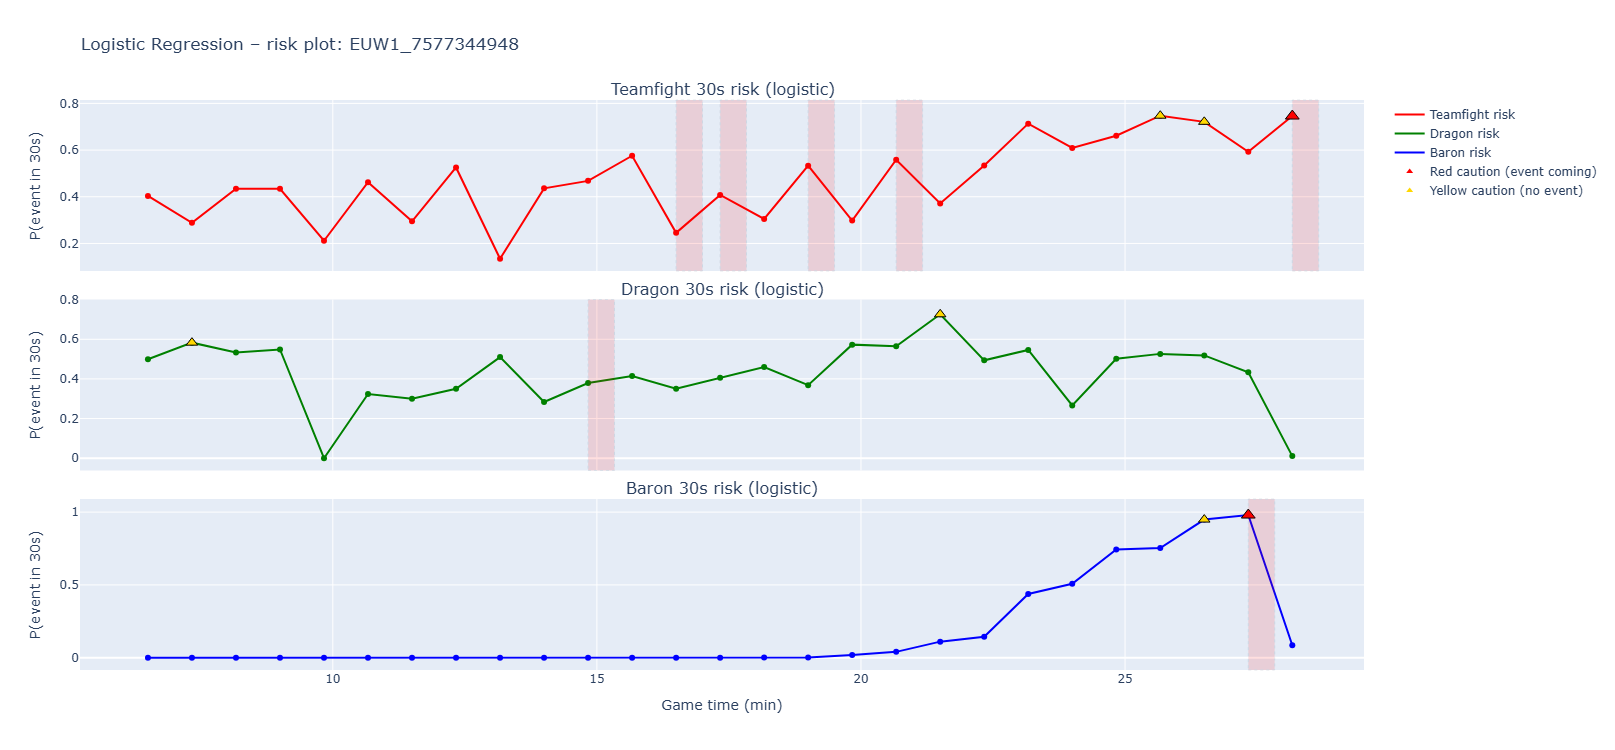

# **Random Forest - model**

In [46]:
def train_rf_per_label(X, y):
    rf_list = []

    for col_idx in range(y.shape[1]):
        rf = RandomForestClassifier(
            n_estimators=120,
            max_depth=5,
            min_samples_leaf=5,
            n_jobs=-1,
            class_weight="balanced_subsample",
            random_state=42
        )

        rf.fit(X, y[:, col_idx])
        rf_list.append(rf)

    return rf_list

rf_models = train_rf_per_label(X_base, y_base)

def predict_rf(model_list, X):
    out_probs = []
    for model in model_list:
        p = model.predict_proba(X)[:, 1]
        out_probs.append(p)
    return np.stack(out_probs, axis=1)

y_test_pred_rf = predict_rf(rf_models, Xte_last)

# **Random Forest - metrics**

In [47]:
rows = []

for name, idx in event_to_idx.items():
    yt = y_test[:, idx].astype(int)
    yp = y_test_pred_rf[:, idx]

    if yt.min() == yt.max():
        auc_val = np.nan
        brier_val = np.nan
    else:
        auc_val = roc_auc_score(yt, yp)
        brier_val = brier_score_loss(yt, yp)

    y_pred_bin = (yp >= 0.5).astype(int)
    prec_val = precision_score(yt, y_pred_bin, zero_division=0)
    tmp = name.split("_")
    event_name = tmp[0]
    horizon_val = int(tmp[1])

    row = {
        "event": event_name,
        "horizon": horizon_val,
        "auc": auc_val,
        "precision": prec_val,
        "brier": brier_val
    }

    rows.append(row)

df_metrics_rf = pd.DataFrame(rows)
df_metrics_rf = df_metrics_rf.sort_values(["event", "horizon"])

event_avg_rf = (df_metrics_rf.groupby("event")[["auc", "precision", "brier"]].mean().reset_index())
display(event_avg_rf)

,event,auc,precision,brier
0,Baron,0.974856,0.049487,0.090621
1,Dragon,0.913631,0.195733,0.165240
2,Teamfight,0.697122,0.139028,0.222651


# **Random Forest - confusion matrix**

In [48]:
def plot_main_conf_mats_rf():
    main_events = ["Baron_30", "Dragon_30", "Teamfight_30"]

    label_names = {
        "Baron": ("No Baron", "Baron"),
        "Dragon": ("No Dragon", "Dragon"),
        "Teamfight": ("No Teamfight", "Teamfight")
    }

    for ev_name in main_events:
        idx = event_to_idx[ev_name]
        y_true = y_test[:, idx].astype(int)
        y_prob = y_test_pred_rf[:, idx]
        y_pred = (y_prob >= 0.5).astype(int)
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        base_name = ev_name.split("_")[0]
        lbl0, lbl1 = label_names[base_name]

        fig = px.imshow(
            cm,
            text_auto=True,
            x=[f"{lbl0}", f"{lbl1}"],
            y=[f"{lbl0}", f"{lbl1}"],
            labels=dict(
                x="Predicted",
                y="Actual",
                color="Count"
            ),
            title=base_name,
            color_continuous_scale="Blues"
        )

        fig.update_layout(width=350, height=350)
        fig.show()

plot_main_conf_mats_rf()


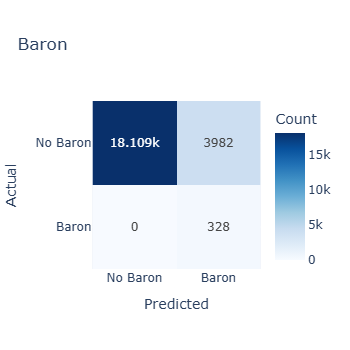

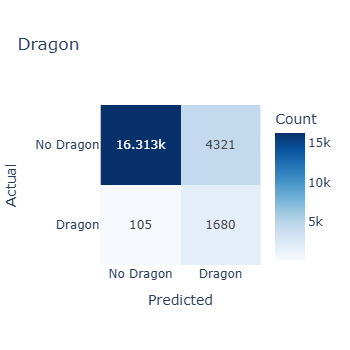

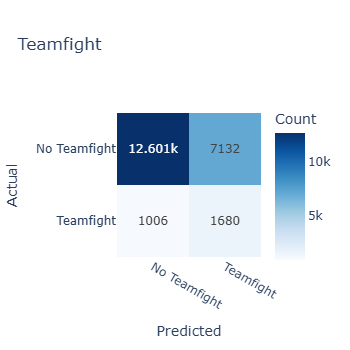

# **Random Forest - ROC curve**

In [50]:
def plot_roc_30_rf():
    fig = go.Figure()
    main_events = ["Baron_30", "Dragon_30", "Teamfight_30"]

    for ev_name in main_events:
        idx = event_to_idx[ev_name]
        y_true = y_test[:, idx].astype(int)
        y_prob = y_test_pred_rf[:, idx]

        if y_true.min() == y_true.max():
            continue

        fpr, tpr, thresh = roc_curve(y_true, y_prob)
        auc_val = roc_auc_score(y_true, y_prob)
        clean_name = ev_name.split("_")[0]
        legend_text = clean_name + " (AUC = " + format(auc_val, ".3f") + ")"

        fig.add_trace(
            go.Scatter(
                x=fpr,
                y=tpr,
                mode="lines",
                name=legend_text
            )
        )

    fig.add_trace(
        go.Scatter(
            x=[0, 1],
            y=[0, 1],
            mode="lines",
            line=dict(dash="dash"),
            name="Random"
        )
    )

    fig.update_layout(
        title="ROC curves – Random Forest",
        xaxis_title="False Positive Rate",
        yaxis_title="True Positive Rate",
        xaxis=dict(range=[0, 1]),
        yaxis=dict(range=[0, 1]),
        width=750,
        height=550
    )

    fig.show()


plot_roc_30_rf()


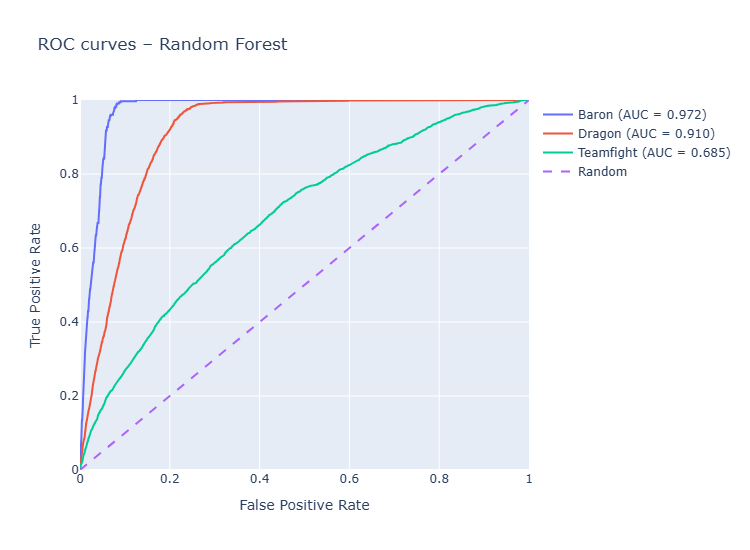

# **Random Forest - risk plot**

In [97]:
def build_match_sequences(df, match_id, seq_len, step):
    g = df[df["match_id"] == match_id].sort_values("t").reset_index(drop=True)
    xf = g[feature_columns].values.astype(np.float32)
    yt = g[target_columns].values.astype(np.float32)

    xs, ys, ts = [], [], []

    for start_idx in range(0, len(g) - seq_len + 1, step):
        end_idx = start_idx + seq_len - 1
        xs.append(xf[start_idx:end_idx+1])
        ys.append(yt[end_idx])
        ts.append(g.loc[end_idx, "t"])

    if len(xs) == 0:
        return (
            np.empty((0, seq_len, len(feature_columns)), np.float32),
            np.empty((0, len(target_columns)), np.float32),
            np.empty((0,), np.float32)
        )

    return np.array(xs), np.array(ys), np.array(ts, dtype=np.float32)


def baseline_seq_predict_rf(X_seq):
    X_last = X_seq[:, -1, :]
    X_last = X_last.reshape(-1, X_seq.shape[-1])
    probs9 = predict_rf(rf_models, X_last)

    return probs9[:, 0:3], probs9[:, 3:6], probs9[:, 6:9]


def pick_warnings(probs, t_sec, prob_floor, min_gap_s=45, max_warn=3):
    cand = np.where(probs >= prob_floor)[0]
    if len(cand) == 0:
        return np.array([], dtype=int)

    clusters = []
    cur = [cand[0]]

    for idx in cand[1:]:
        if t_sec[idx] - t_sec[cur[-1]] <= min_gap_s:
            cur.append(idx)
        else:
            clusters.append(cur)
            cur = [idx]

    clusters.append(cur)

    picks = []
    for c in clusters:
        c = np.array(c)
        picks.append(c[np.argmax(probs[c])])

    picks = np.array(picks, dtype=int)

    if len(picks) > max_warn:
        order = np.argsort(probs[picks])[::-1][:max_warn]
        picks = picks[order]

    return picks


def plot_ews_dashboard_rf(match_id):
    X_seq, Y_seq, T_seconds = build_match_sequences(df, match_id, SEQ_LEN, STEP)
    if X_seq.shape[0] == 0:
        print("No sequences for match", match_id)
        return

    T_min = T_seconds / 60.0
    baron_p, dragon_p, teamfight_p = baseline_seq_predict_rf(X_seq)

    cfg = {
        "Teamfight": {"probs": teamfight_p[:, 2], "y_col": "y_teamfight_30", "color": "red",  "prob_floor": 0.25, "max_warn": 3},
        "Dragon":    {"probs": dragon_p[:, 2],    "y_col": "y_dragon_30",    "color": "green","prob_floor": 0.20, "max_warn": 2},
        "Baron":     {"probs": baron_p[:, 2],     "y_col": "y_baron_30",     "color": "blue", "prob_floor": 0.12, "max_warn": 2},
    }

    fig = make_subplots(
        rows=3,
        cols=1,
        shared_xaxes=True,
        vertical_spacing=0.05,
        subplot_titles=[
            "Teamfight 30s risk (RF)",
            "Dragon 30s risk (RF)",
            "Baron 30s risk (RF)"
        ]
    )

    fig.add_trace(go.Scatter(x=[None], y=[None], line=dict(color="red"),   mode="lines",  name="Teamfight risk"), row=1, col=1)
    fig.add_trace(go.Scatter(x=[None], y=[None], line=dict(color="green"), mode="lines",  name="Dragon risk"),    row=1, col=1)
    fig.add_trace(go.Scatter(x=[None], y=[None], line=dict(color="blue"),  mode="lines",  name="Baron risk"),     row=1, col=1)

    fig.add_trace(go.Scatter(x=[None], y=[None], mode="markers",
                             marker=dict(symbol="triangle-up", color="red", size=12),
                             name="Red caution (event coming)"), row=1, col=1)

    fig.add_trace(go.Scatter(x=[None], y=[None], mode="markers",
                             marker=dict(symbol="triangle-up", color="gold", size=10),
                             name="Yellow caution (no event)"), row=1, col=1)

    order = ["Teamfight", "Dragon", "Baron"]

    for r, ev in enumerate(order, start=1):
        c = cfg[ev]
        probs = c["probs"]
        y_idx = target_columns.index(c["y_col"])
        y_true = Y_seq[:, y_idx].astype(int)

        picked = pick_warnings(
            probs, T_seconds,
            prob_floor=c["prob_floor"],
            min_gap_s=45,
            max_warn=c["max_warn"]
        )

        hit_idx  = picked[y_true[picked] == 1]
        miss_idx = picked[y_true[picked] == 0]

        fig.add_trace(
            go.Scatter(
                x=T_min, y=probs,
                mode="lines+markers",
                line=dict(color=c["color"]),
                showlegend=False
            ),
            row=r, col=1
        )

        if len(hit_idx):
            fig.add_trace(
                go.Scatter(
                    x=T_min[hit_idx], y=probs[hit_idx],
                    mode="markers",
                    marker=dict(symbol="triangle-up", size=12, color="red", line=dict(width=1, color="black")),
                    showlegend=False
                ),
                row=r, col=1
            )

        if len(miss_idx):
            fig.add_trace(
                go.Scatter(
                    x=T_min[miss_idx], y=probs[miss_idx],
                    mode="markers",
                    marker=dict(symbol="triangle-up", size=10, color="gold", line=dict(width=1, color="black")),
                    showlegend=False
                ),
                row=r, col=1
            )

        true_times = np.unique(T_seconds[y_true == 1])
        for t in true_times:
            fig.add_vrect(
                x0=t/60.0, x1=(t+30)/60.0,
                row=r, col=1,
                fillcolor="red", opacity=0.12,
                line_width=1, line_dash="dot"
            )

        if r == 2:
            fig.update_yaxes(title_text="P(event in 30s)")

    fig.update_xaxes(title_text="Game time (min)", row=3, col=1)
    fig.update_layout(height=760, title="Random Forest – risk plot: " + str(match_id))
    fig.show()


plot_ews_dashboard_rf("EUW1_7577344948")

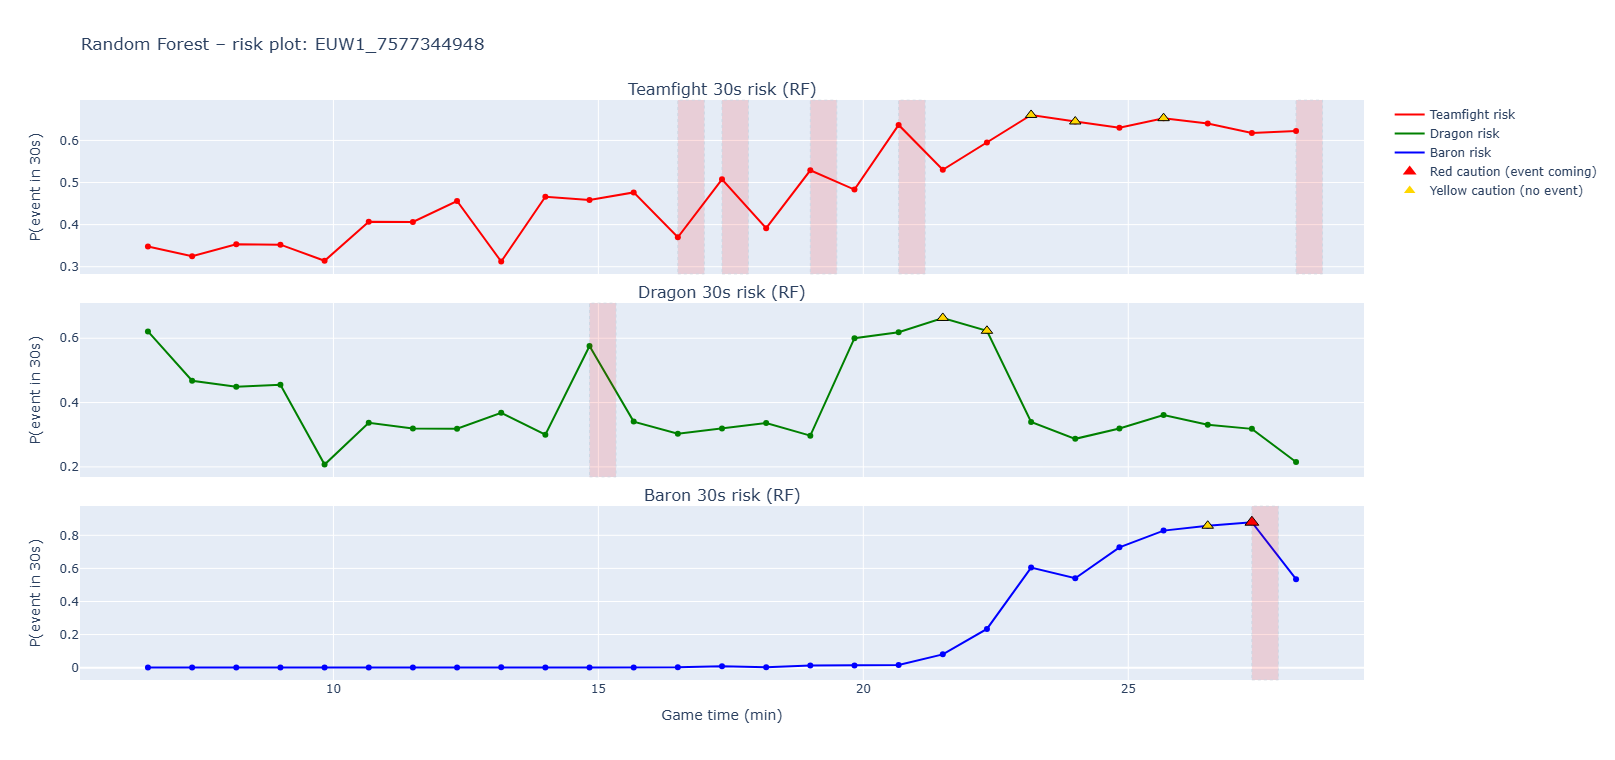

# **Custom build: LeagueEWS = TCN + BiGRU + CrossAttention architecture**

In [63]:
def squeeze_excite(x, r=8):
    f = x.shape[-1]
    se = layers.GlobalAveragePooling1D()(x)
    se = layers.Dense(int(f // r), activation="relu")(se)
    se = layers.Dense(int(f), activation="sigmoid")(se)
    se = layers.Reshape((1, int(f)))(se)
    out = layers.Multiply()([x, se])
    return out

def res_tcn(x, f, k=3, d=1, drop=0.15):

    y = layers.Conv1D(filters=f, kernel_size=k, dilation_rate=d, padding="causal", activation="relu")(x)
    y = layers.BatchNormalization()(y)
    y = layers.Dropout(drop)(y)

    y = layers.Conv1D(filters=f, kernel_size=k, dilation_rate=d, padding="causal")(y)
    y = layers.BatchNormalization()(y)

    y = squeeze_excite(y)

    if x.shape[-1] != f:
        x = layers.Conv1D(f, 1, padding="same")(x)

    out = layers.Add()([x, y])
    out = layers.Activation("relu")(out)
    return out


def cross_att(x1, x2, h=4, d=64):
    att_layer = layers.MultiHeadAttention(num_heads=h, key_dim=d)
    got = att_layer(x1, x2)
    skip = layers.Add()([x1, got])
    out = layers.LayerNormalization()(skip)
    return out


def build_riftseer(seq_len, n_feat):
    inp = layers.Input(shape=(seq_len, n_feat))
    t = res_tcn(inp, 64)
    t = res_tcn(t, 128, k=3, d=2)
    t = res_tcn(t, 128, k=3, d=4)
    t = layers.TimeDistributed(layers.Dense(128, activation="relu"))(t)
    g = layers.Bidirectional(layers.GRU(128, return_sequences=True, dropout=0.3))(inp)
    g = layers.Bidirectional(layers.GRU(128, return_sequences=True, dropout=0.3))(g)
    xx = cross_att(t, g)
    xx = cross_att(xx, inp)
    attn = layers.MultiHeadAttention(4, 64)(xx, xx)
    xx = layers.Add()([xx, attn])
    xx = layers.LayerNormalization()(xx)
    ff = layers.Dense(256, activation="relu")(xx)
    ff = layers.Dense(xx.shape[-1])(ff)
    xx = layers.Add()([xx, ff])
    w = layers.Dense(1, activation="tanh")(xx)
    w = layers.Softmax(axis=1)(w)
    pooled = layers.Multiply()([xx, w])
    pooled = layers.Lambda(lambda z: tf.reduce_sum(z, axis=1))(pooled)

    h = layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(1e-6))(pooled)
    h = layers.Dropout(0.4)(h)
    shared = layers.Dense(256, activation="relu")(h)

    baron_out = layers.Dense(3, activation="sigmoid", name="baron")(layers.Dropout(0.5)(shared))
    dragon_out = layers.Dense(3, activation="sigmoid", name="dragon")(shared)
    fight_out = layers.Dense(3, activation="sigmoid", name="teamfight")(shared)

    model = models.Model(inputs=inp, outputs=[baron_out, dragon_out, fight_out], name="LeagueEWS")
    return model


model = build_riftseer(SEQ_LEN, len(feature_columns))
model.summary()


Model: "LeagueEWS"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 40, 150)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 40, 64)    │     28,864 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 64)    │        256 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 40, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 40, 64)    │     12,352 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 64)    │        256 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 8)         │        520 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 64)        │        576 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1, 64)     │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 40, 64)    │      9,664 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 40, 64)    │          0 │ batch_normalizat… │
│ (Multiply)          │                   │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 40, 64)    │          0 │ conv1d_10[0][0],  │
│                     │                   │            │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 40, 64)    │          0 │ add_7[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 40, 128)   │     24,704 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 128)   │        512 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 40, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 40, 128)   │     49,280 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 128)   │        512 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                 

 Total params: 1,511,090 (5.76 MB)

 Trainable params: 1,509,810 (5.76 MB)

 Non-trainable params: 1,280 (5.00 KB)

# **LeagueEWS - training setup**

In [64]:
EPOCHS = 30
steps_per_epoch = int(np.ceil(len(X_train) / BATCH_SIZE))
total_steps = steps_per_epoch * EPOCHS
initial_lr = 1e-4

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = initial_lr,
    decay_steps = total_steps,
    alpha = 0.2
)

opt = tf.keras.optimizers.AdamW(
    learning_rate = lr_schedule,
    weight_decay = 0.0001
)

class MinEpochEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, monitor="val_loss", min_epochs=12, patience=6, mode="min"):
        super(MinEpochEarlyStopping, self).__init__()
        self.monitor = monitor
        self.min_epochs = min_epochs
        self.patience = patience
        self.mode = mode
        self.best = None
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}


        cur_value = logs.get(self.monitor)
        if cur_value is None:
            return

        if self.best is None:
            self.best = cur_value

        if epoch < (self.min_epochs - 1):
            if (self.mode == "min" and cur_value < self.best) or (self.mode == "max" and cur_value > self.best):
              self.best = cur_value
            return

        improved = False
        if self.mode == "min" and cur_value < self.best:
            improved = True
        if self.mode == "max" and cur_value > self.best:
            improved = True

        if improved:
            self.best = cur_value
            self.wait = 0
        else:
            self.wait += 1

            if self.wait >= self.patience:
                print("\nEarly Stopping at epoch", epoch + 1, "best", self.monitor, "=", float(self.best))
                self.model.stop_training = True


model.compile(
    optimizer = opt,
    loss = {
        "baron"    : "binary_crossentropy",
        "dragon"   : "binary_crossentropy",
        "teamfight": "binary_crossentropy"
    },
    loss_weights = {
        "baron"    : 1.0,
        "dragon"   : 2.0,
        "teamfight": 2.5
    },
    metrics = {
        "baron"    : [AUC(name="baron_auc")],
        "dragon"   : [AUC(name="dragon_auc")],
        "teamfight": [AUC(name="teamfight_auc")]
    }
)

checkpoint_path = "LeagueEWS.keras"

callbacks_list = [
    MinEpochEarlyStopping(
        monitor    = "val_loss",
        min_epochs = 12,
        patience   = 6,
        mode       = "min"
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath       = checkpoint_path,
        monitor        = "val_loss",
        save_best_only = True,
        verbose        = 1
    )
]

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS,
    callbacks = callbacks_list
)

model.load_weights(checkpoint_path)


Epoch 1/30
631/631 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - baron_baron_auc: 0.6627 - baron_loss: 0.1434 - dragon_dragon_auc: 0.5735 - dragon_loss: 0.2468 - loss: 1.3772 - teamfight_loss: 0.2960 - teamfight_teamfight_auc: 0.6355
Epoch 1: val_loss improved from inf to 1.06166, saving model to LeagueEWS.keras
631/631 ━━━━━━━━━━━━━━━━━━━━ 74s 75ms/step - baron_baron_auc: 0.6628 - baron_loss: 0.1433 - dragon_dragon_auc: 0.5736 - dragon_loss: 0.2467 - loss: 1.3769 - teamfight_loss: 0.2960 - teamfight_teamfight_auc: 0.6356 - val_baron_baron_auc: 0.9426 - val_baron_loss: 0.0402 - val_dragon_dragon_auc: 0.7562 - val_dragon_loss: 0.1863 - val_loss: 1.0617 - val_teamfight_loss: 0.2593 - val_teamfight_teamfight_auc: 0.7455
Epoch 2/30
631/631 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - baron_baron_auc: 0.9020 - baron_loss: 0.0411 - dragon_dragon_auc: 0.7558 - dragon_loss: 0.1798 - loss: 1.0540 - teamfight_loss: 0.2613 - teamfight_teamfight_auc: 0.7338
Epoch 2: val_loss improved from 1.06166 to 1.02725, saving 

# **LeagueEWS - metrics**

In [65]:
def stack_out(o):
    if isinstance(o, list) or isinstance(o, tuple):
        return np.concatenate(o, axis=-1)
    else:
        return o

y_test_pred = model.predict(X_test, batch_size=512, verbose=0)
y_test_pred = stack_out(y_test_pred)

event_horizons = [("Baron", 10), ("Baron", 20), ("Baron", 30),
 ("Dragon", 10), ("Dragon", 20), ("Dragon", 30),
  ("Teamfight", 10), ("Teamfight", 20), ("Teamfight", 30),
]

event_names = []
for e, h in event_horizons:
    event_names.append(f"{e}_{h}")

event_to_idx = {}
for i, nm in enumerate(event_names):
    event_to_idx[nm] = i

rows = []
for name, idx in event_to_idx.items():
    yt = y_test[:, idx].astype(int)
    yp = y_test_pred[:, idx]

    try:
        auc_val = roc_auc_score(yt, yp)
        brier_val = brier_score_loss(yt, yp)
    except ValueError:
        auc_val = np.nan
        brier_val = np.nan

    y_bin = (yp >= 0.5).astype(int)
    prec_val = precision_score(yt, y_bin, zero_division=0)
    base_name, horizon_str = name.split("_")
    horizon_num = int(horizon_str)

    rows.append({
        "event": base_name,
        "horizon": horizon_num,
        "auc": auc_val,
        "precision": prec_val,
        "brier": brier_val
    })

df_metrics = pd.DataFrame(rows)
df_metrics = df_metrics.sort_values(["event", "horizon"])

event_avg = (df_metrics.groupby("event")[["auc", "precision", "brier"]].mean().reset_index())
display(event_avg)

,event,auc,precision,brier
0,Baron,0.983210,0.451165,0.006940
1,Dragon,0.918712,0.645204,0.036097
2,Teamfight,0.889846,0.640031,0.052727


# **LeagueEWS - confusion matrix**

In [66]:
def plot_main_conf_mats():
    main = ["Baron_30", "Dragon_30", "Teamfight_30"]
    for event_name in main:
        idx = event_to_idx[event_name]
        yt = y_test[:, idx].astype(int)
        yp = y_test_pred[:, idx]
        y_pred_bin = (yp >= 0.5).astype(int)
        cm = confusion_matrix(yt, y_pred_bin, labels=[0, 1])
        base_event = event_name.split("_")[0]

        fig = px.imshow(
            cm,
            text_auto=True,
            x=["Pred 0", "Pred 1"],
            y=["True 0", "True 1"],
            labels={
                "x": "Predicted",
                "y": "True",
                "color": "Count"
            },
            title=base_event,
            color_continuous_scale="Blues"
        )

        fig.update_layout(
            width=350,
            height=350
        )

        fig.show()

plot_main_conf_mats()


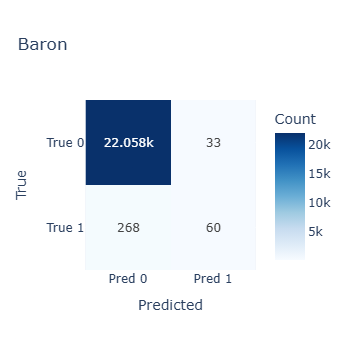

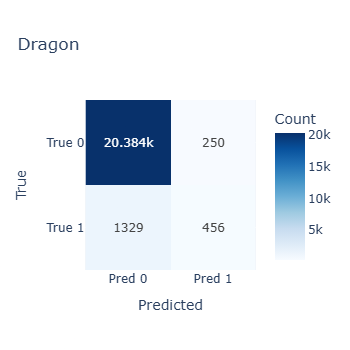

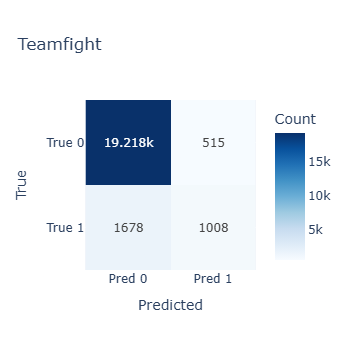

# **LeagueEWS - ROC curve**

In [67]:
def plot_roc_30():
    fig = go.Figure()
    events_list = ["Baron_30", "Dragon_30", "Teamfight_30"]
    for ev in events_list:
        idx = event_to_idx[ev]
        yt = y_test[:, idx].astype(int)
        yp = y_test_pred[:, idx]
        if yt.min() == yt.max():
            continue

        fpr, tpr, whatever_unused = roc_curve(yt, yp)
        auc_val = roc_auc_score(yt, yp)
        short_name = ev.split("_")[0]
        legend_label = short_name + " (AUC = " + format(auc_val, ".3f") + ")"

        fig.add_trace(
            go.Scatter(
                x=fpr,
                y=tpr,
                mode="lines",
                name=legend_label
            )
        )

    fig.add_trace(
        go.Scatter(
            x=[0, 1],
            y=[0, 1],
            mode="lines",
            line=dict(dash="dash"),
            showlegend=True,
            name="Random"
        )
    )

    fig.update_layout(
        title="ROC curves – 30s horizon (test set)",
        xaxis_title="False Positive Rate",
        yaxis_title="True Positive Rate",
        xaxis=dict(range=[0, 1]),
        yaxis=dict(range=[0, 1]),
        width=750,
        height=550
    )

    fig.show()


plot_roc_30()

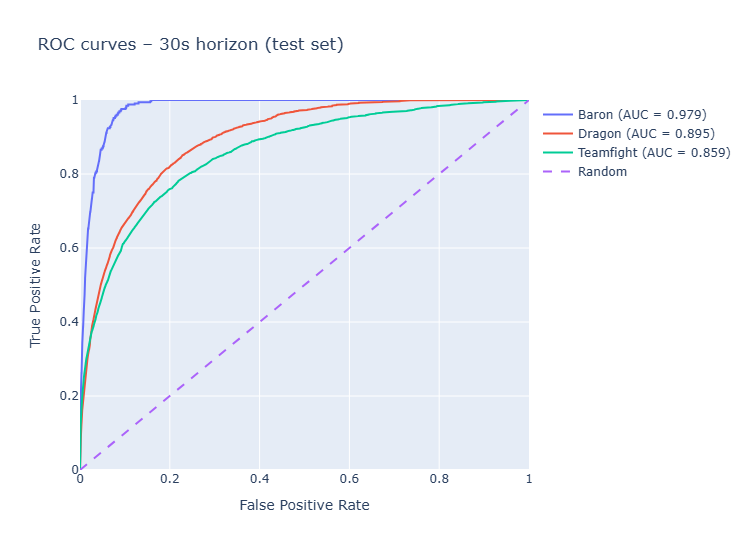

# **LeagueEWS - risk plot**

In [96]:
def plot_ews_dashboard(match_id=None):
    if match_id is None:
        all_ids = df["match_id"].unique()
        match_id = np.random.choice(all_ids)
    print("Using match:", match_id)


    X_seq, Y_seq, T_seconds = build_match_sequences(df, match_id, SEQ_LEN, STEP)
    if X_seq.shape[0] == 0:
        print("No sequences for match", match_id)
        return

    T_minutes = T_seconds / 60.0
    preds = model.predict(X_seq, verbose=0)
    baron_probs = preds[0]
    dragon_probs = preds[1]
    teamfight_probs = preds[2]
    cfg = {
        "Teamfight": {
            "probs": teamfight_probs[:, 2],
            "y_col": "y_teamfight_30",
            "color": "red",
            "prob_floor": 0.25,
            "max_warn": 3
        },
        "Dragon": {
            "probs": dragon_probs[:, 2],
            "y_col": "y_dragon_30",
            "color": "green",
            "prob_floor": 0.20,
            "max_warn": 2
        },
        "Baron": {
            "probs": baron_probs[:, 2],
            "y_col": "y_baron_30",
            "color": "blue",
            "prob_floor": 0.12,
            "max_warn": 2
        }
    }

    event_order = ["Teamfight", "Dragon", "Baron"]

    fig = make_subplots(
        rows=3,
        cols=1,
        shared_xaxes=True,
        vertical_spacing=0.05,
        subplot_titles=[
            "Teamfight 30s risk",
            "Dragon 30s risk",
            "Baron 30s risk"
        ]
    )

    fig.add_trace(go.Scatter(
        x=[None], y=[None], mode="lines",
        line=dict(color="red"),
        name="Teamfight risk"
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=[None], y=[None], mode="lines",
        line=dict(color="green"),
        name="Dragon risk"
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=[None], y=[None], mode="lines",
        line=dict(color="blue"),
        name="Baron risk"
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=[None], y=[None], mode="markers",
        marker=dict(symbol="star", size=12, color="gold", line=dict(width=1, color="black")),
        name="Warning (hit)"
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=[None], y=[None], mode="markers",
        marker=dict(symbol="x", size=10, color="firebrick"),
        name="Warning (false)"
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=[None], y=[None], mode="markers",
        marker=dict(symbol="square", size=12, color="rgba(255,0,0,0.25)"),
        name="Actual event window"
    ), row=1, col=1)


    for r, ev_name in enumerate(event_order, start=1):
        stuff = cfg[ev_name]
        probs = stuff["probs"]
        target_idx = target_cols.index(stuff["y_col"])
        y_true = Y_seq[:, target_idx].astype(int)
        warn_idx = pick_warnings(
            probs,
            T_seconds,
            prob_floor=stuff["prob_floor"],
            min_gap_s=45,
            max_warn=stuff["max_warn"]
        )

        hit_idx = warn_idx[y_true[warn_idx] == 1]
        miss_idx = warn_idx[y_true[warn_idx] == 0]
        n_events = int(y_true.sum())
        n_warn = len(warn_idx)
        n_hits = len(hit_idx)
        n_false = len(miss_idx)

        fig.add_trace(go.Scatter(
            x=T_minutes,
            y=probs,
            mode="lines+markers",
            line=dict(color=stuff["color"]),
            showlegend=False,
            name=ev_name
        ), row=r, col=1)

        fig.add_hline(
            y=stuff["prob_floor"],
            row=r, col=1,
            line_dash="dash",
            line_color=stuff["color"],
            opacity=0.5
        )

        if len(hit_idx) > 0:
            fig.add_trace(go.Scatter(
                x=T_minutes[hit_idx],
                y=probs[hit_idx],
                mode="markers",
                marker=dict(symbol="star", size=13, color="gold",
                            line=dict(width=1, color="black")),
                showlegend=False
            ), row=r, col=1)

        if len(miss_idx) > 0:
            fig.add_trace(go.Scatter(
                x=T_minutes[miss_idx],
                y=probs[miss_idx],
                mode="markers",
                marker=dict(symbol="x", size=10, color="firebrick"),
                showlegend=False
            ), row=r, col=1)

        ev_times = np.unique(T_seconds[y_true == 1])
        for t in ev_times:
            fig.add_vrect(
                x0=t/60.0,
                x1=(t + 30.0)/60.0,
                row=r, col=1,
                fillcolor="red",
                opacity=0.12,
                line_width=1,
                line_dash="dot"
            )

        summary_text = f"Events: {n_events} | Warnings: {n_warn} | Hits: {n_hits} | False: {n_false}"

        fig.add_annotation(
            text=summary_text,
            xref="x domain",
            yref="y domain",
            x=0.99,
            y=0.96,
            xanchor="right",
            yanchor="top",
            showarrow=False,
            font=dict(size=10),
            row=r, col=1
        )

        if r == 2:
            fig.update_yaxes(title_text="P(event in 30s)", row=2, col=1, range=[0,1])

    fig.update_xaxes(title_text="Game time (min)", row=3, col=1)
    fig.update_layout(
        height=740,
        title="League EWS – risk plot:" + str(match_id),
        hovermode="x unified",
        margin=dict(t=80, r=10, l=70, b=60),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )

    fig.show()

plot_ews_dashboard("EUW1_7577344948")

Using match: EUW1_7577344948


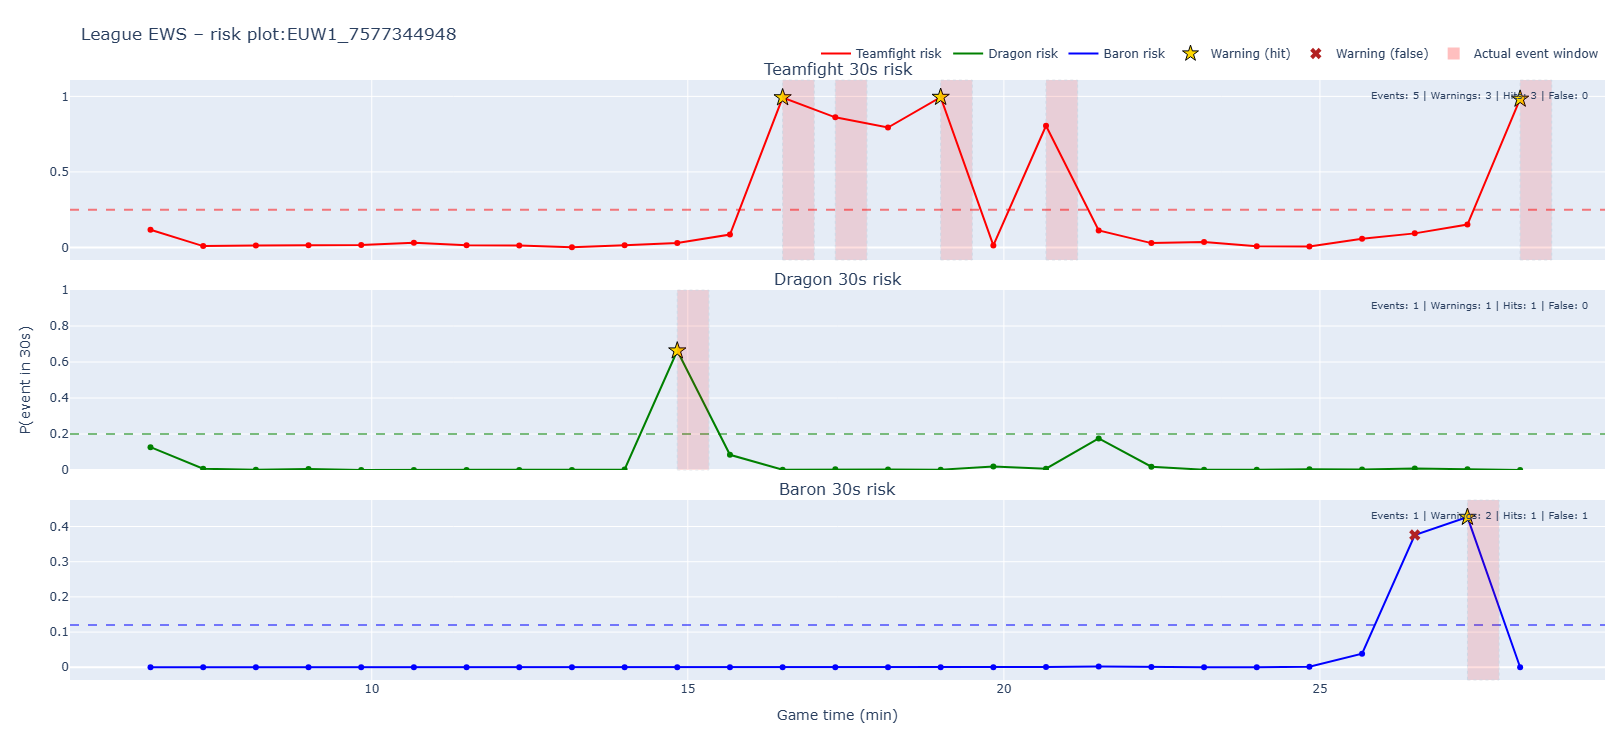